# <p style="text-align: center;"> Adversarial attacks on neural networks </p>

**To avoid readers wasting time on tedious trainings, it is possible to load the pretrained weights of deep neural networks of the section 3.1. directly in a folder:** `weights` <br> 

Note that the lesson tree should be:
```
.
├── Adversarial\ attacks\ on\ neural\ networks.ipynb
├── imagenet1000_clsidx_to_labels.txt
├── imgs
│   ├── static_notebook
│   │   ├── appendix_a_table_1_2.png
│   │   ├── appendix_a_table_3_4.png
│   │   ├── img_1.png
│   │   └── psgd.png
│   └── tb_attacked
│       ├── icecreams.png
│       ├── pandas_img.png
│       └── stop_img.png
├── requirements.txt
└── weights
    ├── adversarial.pth
    └── standard.pth
```

To ensure that it is true, run in the next cell: <br> `! tree` <br>if tree is not installed on your local machine, on **Ubuntu**, you can install it first with <br> `! sudo apt-get install tree`

<details class="alert alert-danger">
    <summary markdown="span"><b>Hardware and environment information (click to expand)</b></summary>


<b> Environment:</b> In order to run this notebook, you'll need some extras packages (`torchtyping` and `tqdm`), they are all listed in `requirements.txt`.
So you can install everything needed in a terminal with a simple... <br> 
`$ pip install -r requirements.txt` 
<br> or in a notebook cell..<br>
`! pip install -r requirements.txt`

<b> Hardware: </b>The notebook does not require a lot of computing power. The Markdown parts have been written to be read in a jupyter notebook. The code was run by 4 CPUs i5 1.4 GHz, 8 GB RAM.
</details>

First, let's import packages...

In [1]:
# Standard libraries
from typing import Callable, Dict, Optional, Tuple, List
from PIL import Image
import glob

# Third-party libraries
import torch
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models
from torchtyping import TensorType
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from scipy.optimize import minimize
from tqdm import tqdm

If you were not able to import `torchtyping`, comment the corresponding import above and in the next cell, put 
```python
NCHW = torch.tensor
CHW = torch.tensor
TargetTensor = torch.tensor
```

In [2]:
NCHW = TensorType["batch_size", "channels", "height", "width"] #torch.tensor
CHW = TensorType["channels", "height", "width"] #torch.tensor
TargetTensor = TensorType["batch_size", "num_classes"] #torch.tensor

And use the device you want... or have!

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

This notebook is extensive, the **non-essential or more advanced parts** are not necessary to understand the concept but are recommended for anyone interested in the topic. These optional parts are labelled with the **`[Going Further]`** flag. 

## <u> Table of contents </u>

1. [Introduction](#sec1)
2. [Taxonomy and presentation of the different attacks](#sec2) <br>
    2.1. [Definitions](#sec21) <br>
    2.2. [Mathematical description of an adversarial attack](#sec22) <br>
    2.3. [Code for an adversarial attack](#sec23) <br>
    2.4. [Other adversarial attacks](#sec24) 
3. [Defending Deep Learning models](#sec3) <br>
    3.1. [Adversarial training](#sec31) <br>
    3.2. [Spectral Analysis of Unstability](#sec32) <br>
4. [Ressources](#sec4) <br>
    4.1. [References](#sec41) <br>
    4.2. [Useful links](#sec42) <br>
5. [Appendices](#sec5)

## 1. <a id="sec1"></a><u> Introduction</u>

**Deep neural networks models have been wildly successful** in many applications such as natural language processing, computer vision, speech, reinforcement learning and so on. These algorithms sometimes outperform human intelligence on several benchmarks. However, they are also sometimes seen as black boxes and their use in critical systems such as medicine, autonomous cars remains inhibited. In addition, an intriguing and worrying property for the use of neural networks is their brittleness to **adversarial attacks method** or **out-of-distribution inputs**.
These adversarial attacks can cause a model with high accuracy to **misclassify an image** by applying a very small perturbation invisible to us humans.

<div class="alert alert-block alert-warning">
In this notebook we will explore the different adversarial attacks and their consequences as well as different attempts to reduce this effect and have a <b>trustfull AI.</b>
    </div>

Thus, the application of an imperceptible disturbance to the input will cause a misclassification of the image. These same perturbations are obtained by **modifying the input towards the prediction error**. These examples are called *adversarial examples*. Even if we use a neural networks to generate a set of adversarial examples are still hard to classify even for neural networks trained with others hyperparameters or with another **training distribution. [[1]](https://arxiv.org/pdf/1312.6199.pdf)**

In several tasks, a **huge amount of models** with different architectures trained on different datasets misclassify the same adversarial example. This suggests that adversarial examples expose blind spots in our training proccess. For a while, the reasons given were that the poor performance of the model on such examples was due to its non-linearity (**with complex layers, $\phi(x)$ non-linear activation functions..**) or its capacity, making it prone to overfit.

<img src="imgs/static_notebook/img_1.png" width="500px"></img>
<p style="text-align: center;"> Fig. 1. Model errors according to its capacity <b><a href="https://www.deeplearningbook.org/contents/ml.html">[2]</a></b> </p>

<br> <br>
However, several studies outline that linear behavior in hig-dimensional spaces is suficient to cause adversarial examples refuting previous explanations. Moreover, even with generic regularization such as dropout, pretrained weights, deep learning models are still exposed to adversarial attacks.

#### First, it is easy to have a linear intuition. 

Let's denote $ x \in \mathbb{R}^{m} $ an input image. Digital images use only 8 bits per pixel so the precision is off $ \frac{1}{255} $

With an adversarial input $ \tilde{x} = x + \eta $, we expect the classifier to assign same class to $x$ and $\tilde{x}$ so long as $ \| \eta\|_{\infty} < \frac{1}{255} $

Now let's consider a single neuron with no activation function inside a linear layer <br> <br>
$$ \omega^T\tilde{x} = \omega^Tx + \omega^T\eta  $$ 

To maximize the perturbation we'll have $ \eta = \epsilon sign(\omega)$

In [4]:
def compute_adversarial_1d(n_dims: int = 10, seed: Optional[int] = None, epsilon: float = 0.003) -> Tuple[int, ...]:
    if seed:
        np.random.seed(seed)
    w = np.random.randn(n_dims)
    x = np.random.randn(n_dims)
    eta = epsilon * np.sign(w)
    x_tilde = x + eta
    
    regular_activation = w.T @ x
    adversarial_activation = w.T @ x_tilde
    
    return regular_activation, adversarial_activation, (adversarial_activation - regular_activation)


dimensions: List[int] = [1, 10, 100, 1000, 5000, 10000, 100000]
for dimension in dimensions:
    print(f'For an input of dimension {dimension}:')
    _, _, difference = compute_adversarial_1d(dimension, seed=42)
    print(f'The adversarial perturbation causes the activation to grow by: {difference:.4f}')
    

For an input of dimension 1:
The adversarial perturbation causes the activation to grow by: 0.0015
For an input of dimension 10:
The adversarial perturbation causes the activation to grow by: 0.0199
For an input of dimension 100:
The adversarial perturbation causes the activation to grow by: 0.2168
For an input of dimension 1000:
The adversarial perturbation causes the activation to grow by: 2.3385
For an input of dimension 5000:
The adversarial perturbation causes the activation to grow by: 11.9180
For an input of dimension 10000:
The adversarial perturbation causes the activation to grow by: 23.9854
For an input of dimension 100000:
The adversarial perturbation causes the activation to grow by: 239.6289


This small example shows how small perturbations on each of the inputs can modify the output of a neuron if the input is of sufficiently high dimension, even for problems with well-separated classes where we expect the classifier $f: \mathbb{R}^{m} \longrightarrow \{1, ..., k\} $ to assign the same class to $x$ and $\tilde{x}$. **[[3]](https://arxiv.org/abs/1412.6572)**

*A bit of context...*

During the [2017 Conference on Neural Information Processing Systems (NeurIPS)](https://nips.cc/Conferences/2017), a prestigious competition hosted by **[Google Brain](https://research.google/teams/brain/)** was the **Competition on Adversarial attacks and Defenses** outlining that it is a burning topic in the Machine Learning community.

## 2. <a id="sec2"></a> <u>Taxonomy and presentation of adversarial attacks</u>

### 2.1. <a id="sec21"></a> <u>Formal definitions</u>

<div class="alert alert-block alert-success">
First, let's try to give some formal definitions here! <b><a href="https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7"> [4]</b> </a><br> <br> 
    <b> Adversarial image: </b> it is an image that has been slightly modified in order to fool the classifier, i.e an image were the original is correctly classified but the modified one is not. The measure of modification is usually $ \| .\|_{\infty} $ to measure the maximum change in a single pixel. <br> <br>
    <b> White-box attack: </b> attack where the model's parameters/weights can be used.. <br> <br>
    <b> Black-box attack: </b> attack where the model's parameters/weights can not be used.. <br> <br>
    <b> Non-targeted attack: </b> attack aiming to enforce the model to misclassify the adversarial image <br> <br>
    <b> Targeted attack: </b> attack aiming to enforce a specific target class..
</div>

### <a id="sec22"></a>2. 2. <u>Mathematical description of an adversarial attack [[1]](https://arxiv.org/pdf/1312.6199.pdf)</u>

*This example is a white-box, targeted attacks*

$ f: \mathbb{R}^{m} \longrightarrow \{1...k\}$ : the classifier <br>
$ J: \mathbb{R}^{m} \times \{1...k\} \longrightarrow \mathbb{R}^+$ : the loss function <br>


**Box-constrained optimization problem:**

Minimize $ \| r\|_{2} $ s.t. <br>
- $ f(x + r) = l, l \in \{1...k\}$ <br>
- $ x + r \in [0, 1]^m$ <br>

$x + r$ is the closest image to $x$ classified as $l$ by $f$. The task is interesting and non-trivial when $f(x) \neq l$.

The problem is hard an can be approximate by using a box-constrained L-BFGS-B algorithm.
We can approximate this problem by performing line-search to find the minimum $c >0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$

* Minimize $c\|r\|_2+ J(x + r, l) $ s.t. $x + r \in [0, 1]^m$

### <a id="sec23"></a>2. 3. <u>Code for an adversarial attack</u> [To be fixed]

The next cell is just a simple neural network `FC(100-100-10)` training, it is adapted from [PyTorch Documentation](https://pytorch.org/tutorials/beginner/basics/intro.html), so you can just run the cell without thinking, it does not matter! 

In [5]:
torch.manual_seed(0)
trainset = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

train_loader  = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=256,
                                          shuffle=True)

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=256,
                                          shuffle=False)


class IPNN(nn.Module):
    def __init__(self) -> None:
        super(IPNN, self).__init__()
        self.dense1 = nn.Linear(28 * 28, 100)
        self.dense2 = nn.Linear(100, 100)
        self.dense3 = nn.Linear(100, 10)
        
    def forward(self, x: NCHW) -> TargetTensor:
        x = x.view(-1, 28 * 28)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        
        return x


def train_loop(dataloader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")

weight_decay = 0
model = IPNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

epochs = 5
for t in range(epochs):
    print(f'--- epoch {t+1}/{epochs} ---')
    train_loop(train_loader, model, loss_fn, optimizer)
test_loop(test_loader, model, loss_fn)

torch.save(model.state_dict(), 'weights/no_lipschitz.pth')

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
--- epoch 1/5 ---
--- epoch 2/5 ---
--- epoch 3/5 ---
--- epoch 4/5 ---
--- epoch 5/5 ---
Test Error: 
 Accuracy: 96.6%


<div class="alert alert-block alert-warning">
    Now that we have a <b>highly accurate</b> - <it>near 97%</it> - model on the test set, we will isolate an image and try to generate an adversarial image from this image.
</div>

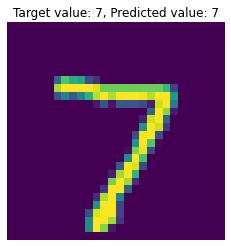

In [6]:
image, target = testset[0]
prediction = model(image).argmax()
plt.imshow(image.squeeze().numpy())
plt.title(f'Target value: {target}, Predicted value: {prediction}')
plt.axis('off')
plt.show()

By resolving the box-constrained problem with L-BFGS-B, we will try to transform this `7` into a `3` and suppose we found $c = 0.01$

In [7]:
def function(r_init):
    r = torch.from_numpy(r_init)
    r = r.view(1, 1, 28, 28)
    img = image.unsqueeze(dim=0) + r
    prediction = model(img.float())
    predicted = prediction.argmax()
    loss = loss_fn(prediction, torch.tensor([3])).item()
    return 0.01 * np.linalg.norm(r_init, ord=2) + loss

In [8]:
np.random.seed(41)
bounds = [(-x.item(), 1 - x.item()) for x in image.view(784)]
res = minimize(function, np.random.randn(784)/10, method="L-BFGS-B", bounds=bounds)
r = res.x

Now let's see how our model is working with a new adversarial image $\tilde{x} = x + r$.
Note that the perturbation is very hard to see with the naked eye

In [9]:
r = torch.from_numpy(r)
r = r.view(1, 28, 28)

adv_img = image + r

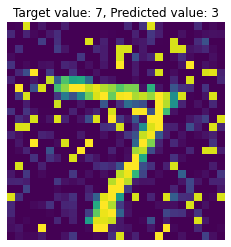

In [10]:
adv_prediction = model(adv_img.float()).argmax()

plt.imshow(adv_img.squeeze().numpy())
plt.title(f'Target value: {target}, Predicted value: {adv_prediction}')
plt.axis('off')
plt.show()

So we managed to fool the model into predicting a `3` when a human clearly sees a `7`.

#### [Important] - Conclusion

<div class="alert alert-block alert-warning">
    The work of Szegedy et al (2014b) <b><a href="https://arxiv.org/pdf/1312.6199.pdf">[1]</b></a> outlined that:

- The method L-BFGS-B can easily find adversarial examples and have a **100% fooling rate for a specific classifier.** <br>
- An adversarial image is often misclassified by **other models (with different architectures)** and/or **trained with other hyperparameters.** - *Cross model generalization*
- Networks trained on a **disjoint subset of the training data** often misclassified the adversarial image. - *Cross training-set generalization* <br> <br>
</div>

**Adversarial images therefore have sort of universal properties!** **[[1]](https://arxiv.org/pdf/1312.6199.pdf)** <br> <br>
*The more detailed results of the study of these phenomena are presented in Appendix A.*


### <a id="sec24"></a>2.4. <u>Other adversarial attacks</u>

The previous adversarial attack is **reliable but solving the operational research problem requires a lot of computing time.**<br> <br>
Moreover, the linear view presented in *Introduction* suggests that we can find fast way to generate adversarial images. The work of Szegedy et al. **[[3]](https://arxiv.org/abs/1412.6572)** hypothesize that neural networks are too linear (even *Sigmoid one*) to resist linear adversarial perturbation.

This suggests that it is possible to fool models with fast and easy methods **gradient-based**. Some of them were presented during [NeurIPS 2017 Competition](https://nips.cc/Conferences/2017/CompetitionTrack) and **we'll explore a curated list of such attacks.**

Since the previous model was really simple, we will try to fool a `ResNet18` with more capacity.

<u><b> Notation </u></b>: In the following parts, $\theta$ is refering to the parameters of a model, $y$ the target associated to the image $x$ and $J(\theta,x,y)$ the loss used to train the network.


Now let's code the framework, this cell only contains useful functions to handle image loading, displaying, defining the pretrained `ResNet18`...

In [11]:
# Utility functions
def load_image(path: str) -> NCHW:
    img = Image.open(path)
    
    transform = Compose([Resize(256), CenterCrop(224), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    tensor = transform(img)
    tensor = tensor.unsqueeze(0)
    
    return tensor


def display_image(tensor: NCHW) -> np.ndarray:
    tensor = tensor.squeeze()
    tensor[0, :, :] = (tensor[0, :, :] * 0.229) + 0.485 
    tensor[1, :, :] = (tensor[1, :, :] * 0.224) + 0.456
    tensor[2, :, :] = (tensor[2, :, :] * 0.225) + 0.406
    
    return tensor.permute(1, 2, 0).detach().numpy()


def from_directory_to_path_list(directory: str) -> List[str]:
    return glob.glob(f'{directory}*.png')


def from_index_to_class_imagenet(index: int, file: str = "imagenet1000_clsidx_to_labels.txt") -> str:
    with open(file, 'r') as f:
        lines = f.readlines()
    
    target = lines[index].split(':')[1][2:-3]
    return target[:30]
    
    
def plot_attack(path: str, method: str = 'fsgm', target: Optional[int] = None) -> None:
    image = load_image(path)
    with torch.no_grad():
        pred_orig = model(image).argmax()
    if method == 'fsgm':
        image_adv, pred_adv, _ = fgsm_attack(model, image.to(device), torch.tensor([pred_orig], device=device))
    elif method == 't-fsgm':
        if target is None:
            raise ValueError('t-fsgm is a targeted attack and need a correct target to proceed (ImageNet)')
        image_adv, pred_adv = targeted_fgsm_attack(model, image.to(device), torch.tensor([target], device=device))
        
    image = display_image(image)
    image_adv = display_image(image_adv)
    
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Original: {from_index_to_class_imagenet(pred_orig)}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image_adv)
    plt.title(f"Adversarial: {from_index_to_class_imagenet(pred_adv)}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(image_adv - image).mean(axis=2))
    plt.title('Difference averaged channel-wise')
    plt.axis('off')
    
    plt.show()
    
    
paths = from_directory_to_path_list('imgs/tb_attacked/')
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval();

<b> <u> Fast Gradient Sign Method</u> [[3]]("https://arxiv.org/abs/1412.6572") </b> <br>
<p style="text-align: center;"> Untargeted, white-box attack <br>
$ \tilde{x} = x + \eta$ <br>
with $\eta = \epsilon sign(\nabla_{x}J(\theta, x, y))$ </p>

In [12]:
def fgsm_attack(model: nn.Module, inputs: NCHW, pred_orig: torch.tensor, max_attacks = 100, epsilon: float = 1e-3, verbose: bool = True) -> Tuple[NCHW, int, int]:
    image_adv = inputs.detach().clone()
    for i in range(max_attacks):
        model.zero_grad()
        image_adv.requires_grad = True
        outputs = model(image_adv.to(device))
        loss = F.cross_entropy(outputs, target=pred_orig)
        loss.backward()
        image_adv.requires_grad = False
        grad = image_adv.grad.data
        image_adv = torch.clamp(image_adv + epsilon * grad.sign(), -2, 2)
        with torch.no_grad():
            pred_adv = model(image_adv.to(device)).argmax()
        
        if pred_adv.item() != pred_orig:
            if verbose:
                print(f'It tooks {i} iterations to generate an adversarial image that fooled the network')
            break
    
    return image_adv, pred_adv.item(), i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


It tooks 8 iterations to generate an adversarial image that fooled the network


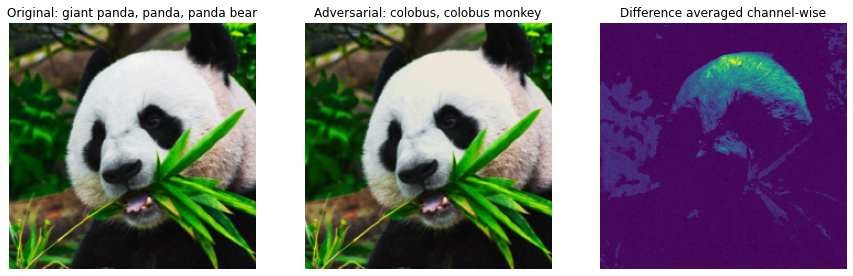

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


It tooks 1 iterations to generate an adversarial image that fooled the network


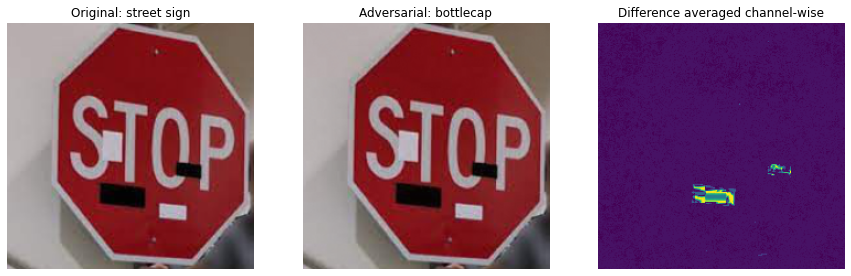

It tooks 1 iterations to generate an adversarial image that fooled the network


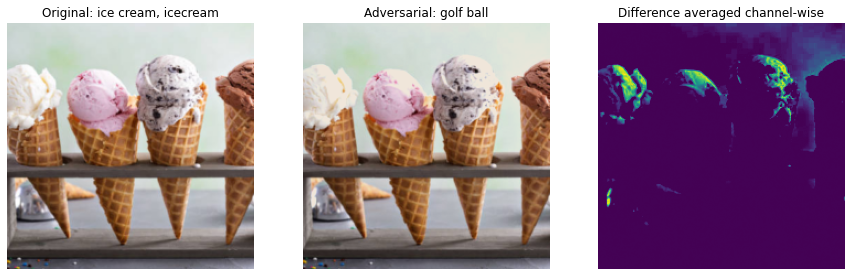

In [13]:
for path in paths:
    plot_attack(path, method='fsgm')

<b> <u> Targeted Fast Gradient Sign Method</u> [[5]]("http://bengio.abracadoudou.com/publications/pdf/kurakin_2017_iclr_physical.pdf") </b> <br>
<p style="text-align: center;"> Targeted, white-box attack <br>
$ \tilde{x} = x + \eta$ <br>
with $\eta = - \epsilon sign(\nabla_{x}J(\theta, x, y_{target}))$ </p>

where $ y_{target}$ is the target you want the model to output for your adversarial image. Let's take our previous images and try to make our network predict them as `burrito` (corresponding ImageNet index: 965). Feel free to look for the class you want by checking the look-up table `imagenet1000_clsidx_to_labels.txt` in the repository

In [14]:
def targeted_fgsm_attack(model: nn.Module, inputs: NCHW, target: torch.tensor, epsilon: float = 1e-3, max_attacks: int = 100) -> Tuple[NCHW, int]:
    image_adv = inputs.detach().clone()
    for i in range(max_attacks):
        model.zero_grad()
        image_adv.requires_grad = True
        outputs = model(image_adv)
        loss = torch.nn.functional.cross_entropy(outputs, target=target)
        loss.backward()
        image_adv.requires_grad = False
        grad = image_adv.grad.data
        image_adv = torch.clamp(image_adv - epsilon * grad.sign(), -2, 2)
        with torch.no_grad():
            pred_adv = model(image_adv).argmax()
        
        if pred_adv.item() == target:
            print(f'It tooks {i} iterations to generate an adversarial image that fooled the network')
            break
    
    return image_adv, pred_adv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


It tooks 18 iterations to generate an adversarial image that fooled the network


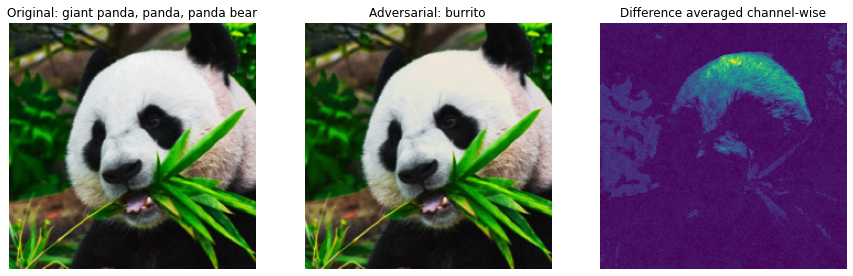

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


It tooks 7 iterations to generate an adversarial image that fooled the network


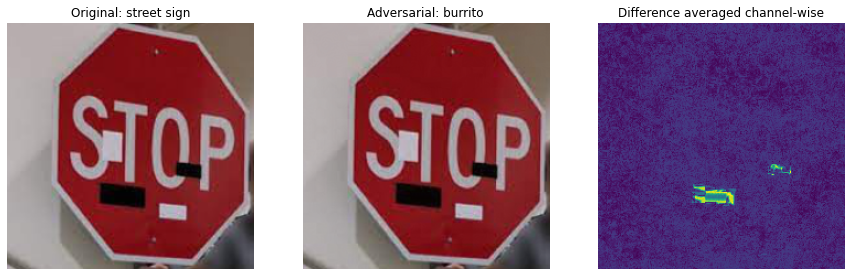

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


It tooks 10 iterations to generate an adversarial image that fooled the network


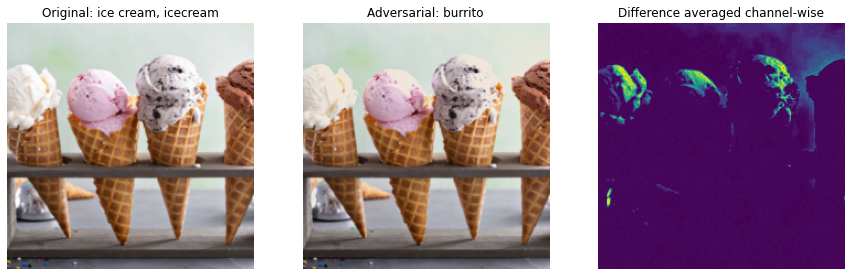

In [15]:
for path in paths:
    plot_attack(path, method='t-fsgm', target=965)

<b> <u> Random Fast Gradient Sign Method</u> [[6]]("https://arxiv.org/abs/1705.07204") </b> <br>
<p style="text-align: center;"> Untargeted, white-box attack <br>
    $\tilde{x} = x + \eta $ <br>
    with $\eta = (\epsilon - \alpha) sign(\nabla_{x'}J(\theta, x',y)) + x'$ <br>
    with $x' = x + \alpha sign(\mathcal{N}(O^{d}, I^{d}))$ </p> <br>
    
FGSM variant where we add random perturbations sampled from a **gaussian distribution**. The motivation is to avoid defenses that rely on gradient masking **[[7]](https://arxiv.org/abs/1602.02697)**. (*Not covered in this notebook*)<br> <br>


<b> <u> Carlini & Wagner Attack</u> [[8]]("https://arxiv.org/abs/1608.04644") </b> <br>  
Targeted, white-box attack <br> Extension of the first attack presented based on L-BFGS-B **[[1]](https://arxiv.org/pdf/1312.6199.pdf)**. It uses a different loss than standard cross-entropy:<br> <br>
$$J(\tilde{x}) = max(max\{g(\tilde{x})_i: i \neq l\} - g(\tilde{x})_l, - \kappa)$$ <br> <br>
where $g: \mathbb{R}^{m} \longrightarrow \mathbb{R}^{n\_classes}$ : the output of the classifier before the `softmax` layer. <br>
and $\kappa$ a constant controlling the desired confidence score ($\kappa$ small means a low confidence adversarial example). <br> <br>
<div class="alert alert-block alert-warning">
Here we want to optimize the distance between the target class $l$ and the most-likely class. <br>
If the <b>$l$-th output is the highest, then the difference will be negative</b> and the optimization will stop when it is at most $\kappa$. On the other hand, if the $i$-th output ($i \neq l$) is the highest the <b>gap between the real target and the target we want will get thiner.</b> 
    </div> <br> <br>
Another loss function in Carlini & Wagner attack slightly modified is: <br> <br>
$$ \|\frac{1}{2}(tanh(r) + 1) - x\|_p^{2} + c J(\frac{1}{2}(tanh(r) + 1) $$ with $ p \in \{1, 2, \infty\}$

# <a id="sec3"></a> 3. <u>Defending Deep Learning models</u>

<div class="alert alert-block alert-success">
A trivial solution for <b>a model to be robust would be to incorporate the adversarial examples a posteriori</b>. This solution, although it works <a href="https://arxiv.org/pdf/1312.6199.pdf"> <b>[1]</b></a>, remains <b>naive and time-consuming</b>. First, a model need to be <b>trained</b>, then the <b>adversarial examples are generated </b>using a fast method or the solution of an optimization problem, and then are <b>incorporated into the training set.</b><br> In this section we will look at how to overcome this pitfall and explore the stability of networks.
</div>

### <a id="sec31"></a> 3.1. <u>Adversarial training</u>

Szegedy et al. **[[3]](https://arxiv.org/abs/1412.6572)** outlines that training a model with an adversarial objective function based on the previous FGSM attack.

A penalty factor is added to the loss in order to regularize effectively: <br> <br>

$$ \tilde{J}(\theta, x, y) = \alpha J(\theta, x, y) + (1 - \alpha)J(\theta, x + \epsilon sign(\nabla_{x}J(\theta, x, y), y) $$
with $\alpha$ a constant. <br>

By using Taylor expansion on the previous loss we can have a surrogate loss:

$$\tilde{J}(\theta, x, y) = \alpha J(\theta, x, y) + (1 - \alpha)[J(\theta, x, y) + \epsilon sign(\nabla_{x}J(\theta, x, y))\nabla_{x}J(\theta, x, y)] + o(\epsilon sign(\nabla_{x}J(\theta, x, y))) $$ <br>

$$\tilde{J}(\theta, x, y) \approx J(\theta, x, y) + (1 - \alpha)\epsilon sign(\nabla_{x}J(\theta, x, y))\nabla_{x}J(\theta, x, y) $$ <br>


> $$\tilde{J}(\theta, x, y) = J(\theta, x, y) + (1 - \alpha)\epsilon \|\nabla_{x}J(\theta, x, y)\|_{1} $$ 


<br>
This last expression outlines that adversarial training can be seen as a kind of $L_{1}$ regularization. It is even more linked in the case of logistic regression. <a href="https://arxiv.org/abs/1412.6572"><b>[3]</b></a>

<div class="alert alert-block alert-success">
In the next cells, we will present the comparison between two models, the first one trained in a standard way, the second one with adversarial training. Both model are trained on <b>MNIST</b> which is public and available on PyTorch unlike <b>ImageNet</b>.
</div>

Training is time consuming and is not the purpose of this notebook. Care has been taken to train the models properly beforehand. For transparency, the training code, run on [Google Colab](https://colab.research.google.com/?utm_source=scs-index), which led to the weights we will use is available in [`Appendix B`](#sec5).
A `LeNet5` was trained over `5` epochs, with `Adam` as optimizer, without penalty and a `learning rate` of $1e-3$

In [16]:
standard_weights: str = 'weights/standard.pth'
adversarial_weights: str = 'weights/adversarial.pth'
    
    
class LeNet5(torch.nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)   
        self.fc2 = nn.Linear(120, 84)       
        self.fc3 = nn.Linear(84, 10)    
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.max_pool2d(x, 2) 
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    
def get_model_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader, attack: bool = False, epsilon: float = 0.15) -> float:
    model.eval()
    correct = 0
    
    for X, y in tqdm(dataloader, desc="Testing.."):
        X = X.to(device)
        y = y.to(device)
        if attack:
            X = fgsm_step(model, X.to(device), y, epsilon)
        with torch.no_grad():
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    correct /= len(dataloader.dataset) 
    return correct


def fgsm_step(model: nn.Module, inputs: NCHW, target: torch.tensor, epsilon: float = 0.15) -> NCHW:
    image_adv = inputs.detach().clone()
    model.zero_grad()
    image_adv.requires_grad = True
    pred = model(image_adv)
    loss = F.cross_entropy(pred, target=target)
    loss.backward()
    grad = image_adv.grad.data
    image_adv = torch.clamp(image_adv + epsilon * grad.sign(), -2, 2)
    return image_adv

Let's load pretrained weights and see how a model trained in a standard way will perform on the test set

In [17]:
model = LeNet5()
model = model.to(device)
model.load_state_dict(torch.load(standard_weights, map_location=device))

transforms = Compose([ToTensor()])

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms,
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=512,
                                          shuffle=False)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Let's compare its accuracy on the regular `MNIST` test set and on the adversarial test set..

In [18]:
clean_accuracy = get_model_accuracy(model, test_loader, attack=False)
adversarial_accuracy = get_model_accuracy(model, test_loader, attack=True)

Testing..: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


In [19]:
clean_accuracy, adversarial_accuracy

(0.9795, 0.1356)

In [20]:
model.load_state_dict(torch.load(adversarial_weights, map_location=device))

clean_accuracy = get_model_accuracy(model, test_loader, attack=False)
adversarial_accuracy = get_model_accuracy(model, test_loader, attack=True)

Testing..: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


In [21]:
clean_accuracy, adversarial_accuracy

(0.9762, 0.7996)

#### Comparison

|   Metrics   |   Standard training |   Adversarial training ($\epsilon = 0.3$) | 
|---    |:-:    |:-:    |
|   Standard accuracy |   0.98  |   0.98 |   
|   Adversarial accuracy ($\epsilon = 1.5e-1$) |   0.14   |   0.80 | 

Thus, adversarial training brings enormous robustness to the models. A simple experiment on MNIST produces impressive results. The full results can be found in the work of Szegedy et al. **[[3]](https://arxiv.org/abs/1412.6572)**

### <a id="sec32"> </a> <u>[Going Further] - Spectral Analysis of Unstability </u>

In the previous part, we saw how to perform adversarial training in order to counter FGSM attack. Although this technique works very well, it does not explain why the models are not robust. In the following section we will study a property that is true for all feedforward networks and its impact on the robustness of these models.

<details class="alert alert-block alert-warning">
    <summary markdown="span"><b>Lipschitz reminder (click to expand)</b></summary>
Let's have E and F two metric spaces (with $d_{E}$ and $d_{F}$ respectively), $f: E \longrightarrow F$ is Lipschitz continuous if there is a $L \in \mathbb{R}$ such that $\forall x, y \in E$, $$d_{F}(f(x), f(y)) \leq Ld_{E}(x, y)$$
<br> 
    
For the particular case where $E = F = \mathbb{R}$, $$|f(x) - f(y)| \leq L|x - y|$$
    
<br> <br>
    
<b>Useful property:</b> the composition of a $k_1$-lipschitz function with a $k_2$-lipschitz function is a $k_1 k_2$-lipschitz function
    </details>

Szegedy et al. **[[1]](https://arxiv.org/pdf/1312.6199.pdf)** described a simple procedure to measure and control the additive stability of each layer.

<u>**Notation:**</u> $\phi_k$ and $ \theta_k$ denotes the operator mapping layer $k - 1$ to layer $k$ and the weights associated. <br>


$f$ is a classifier with $K$ layers. <br>
$x \in \mathbb{R}^m$, $f(x) = \phi_K(\phi_{K-1}(...\phi_1(x;\theta_1);\theta_2)...;\theta_K)$


$L_k$ corresponds to the upper Lipschitz constant of the $k$-th layer <br>

$L_f$ the upper Lipschitz constant of the feedforward network, we have thanks to the property reminded above..

$$L_f \leq \prod_{k=1}^{K} L_k$$ and so,

$$\|f(x) - f(x + r)\| \leq L_f \|r\| $$


In the case of dense network, we have, under the $p$-norm <br> <br> $$\phi_k(x;\theta_k, b_k) = \theta_k x + b_k$$

$$\|(\theta_k x + b_k) - (\theta_k (x + r) + b_k)\|_{p} = \|\theta_k r \|_p$$

$$ \| \theta_k r \|_p \leq L_k \|r\|_p $$

that can be rearranged, considering $r \neq \vec{0}$ $$ \frac{\|\theta_k r \|_p}{\|r\|_p} \leq L_k $$

Then, in order to compute the smallest Lipschitz constant we have:
<br> <br>
$$ L_k = \sup_{r \neq \vec{0}} \frac{\|\theta_k r \|_p}{\|r\|_p} $$ <br> <br>

<b>which is the definition of the operator norm of $\theta_k$</b> <br> <br>

<u><b> Nota Bene: </b></u> for $p = 2$, the operator norm is the spectral norm (i.e is given by the largest singular value of the weight matrix). **[[8]](https://arxiv.org/abs/1802.05957)**

The same work to compute an upper bound of the Lipschitz constant was done for convolutional layers, pooling layers, batch normalization, activation function, residual connections...

But for now let's see how the very first model we trained, `IPNN`, is robust to FGSM attack

In [22]:
no_lipschitz_weights: str = 'weights/no_lipschitz.pth'
model = IPNN()
model = model.to(device)
model.load_state_dict(torch.load(no_lipschitz_weights, map_location=device))

transforms = Compose([ToTensor()])

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms,
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=512,
                                          shuffle=False)

In [23]:
get_model_accuracy(model, test_loader, attack=True, epsilon=0.07)

Testing..: 100%|██████████| 20/20 [00:00<00:00, 23.78it/s]


0.0387

As we've seen earlier, it performs poorly..  <br> <br>
It has been proven that bounding the Lipschitz constant of a neural network provides certifiable robustness guar- antees against adversarial attacks. **[[10]](https://arxiv.org/abs/1811.08080)**


**Constraining the Lipschitz constant of a network can be done by constraining the Lipschitz constant of each layer in isolation.** So training a feedforward network and constraining its Lipschitz constant to be less or equal to $\lambda^d$ revolve around solving a constrained optimisation problem. This problem can be adressed by performing a variant of the projected stochastic gradient method. **[[9]](https://arxiv.org/pdf/1804.04368.pdf)**
In the following notation, $W_i = \theta_i$.

<img src="imgs/static_notebook/psgd.png" width="700px"></img>
<p style="text-align: center;"> Fig. 2. Projected stochastic gradient method. <b><a href="https://arxiv.org/abs/1811.08080">[10]</a></b> </p>
<br> <br>

with $$\pi(W, \lambda) = \frac{1}{max(1, \frac{\|W\|_p}{\lambda})}W$$

In [24]:
class LipschitzConstantConstraint(object):
    def __init__(self, lamb=0.5):
        self.lamb = lamb

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            wprime = w.clone().detach()
            w.mul_(1 / (max(1, (torch.linalg.norm(wprime.flatten(), ord=2) / self.lamb))))

Note that here we are using norm $l_2$ (`torch.linalg.norm(..., ord=2)`) for this example.<br> <br>
Now let's train the model!

**The magic happens** with the piece of code: `model.apply(lipschitz_fn)` in the training loop, which allows to iteratively take care of the weights of the network layers.

In [25]:
model = IPNN()
model = model.to(device)
transforms = Compose([ToTensor()])
lipschitz_cc = LipschitzConstantConstraint(lamb=2.5)

trainset = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms,
                          download=True)

train_loader  = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=512,
                                          shuffle=True)

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms,
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=512,
                                          shuffle=False)

def train_loop(dataloader, model, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = F.cross_entropy(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # HERE WE APPLY THE PROJECTION
        model.apply(lipschitz_cc)
        
        
def test_loop(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing"):
            pred = model(X.to(device))
            test_loss += F.cross_entropy(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: {test_loss} \n Accuracy: {(100*correct):>0.1f}%")

weight_decay = 0   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

epochs = 5
for t in range(epochs):
    print(f'--- epoch {t+1}/{epochs} ---')
    train_loop(train_loader, model, optimizer)
test_loop(test_loader, model)

torch.save(model.state_dict(), 'weights/lipschitz.pth')

--- epoch 1/5 ---
--- epoch 2/5 ---
--- epoch 3/5 ---
--- epoch 4/5 ---
--- epoch 5/5 ---


Testing: 100%|██████████| 20/20 [00:00<00:00, 27.12it/s]

Test Error: 0.9428062975406647 
 Accuracy: 79.8%


In [26]:
get_model_accuracy(model, test_loader, attack=True, epsilon=0.07)

Testing..: 100%|██████████| 20/20 [00:00<00:00, 23.69it/s]


0.2179

A simple experiment on MNIST shows that by constraining the Lipschitz constant of all the layers to remain below 2.5 (for instance), even if on the clean test set the accuracy is weak. We can see that on the corrupted test set, we achieve an accuracy of 0.22 against 0.04 (more than 5 times better) for the standard model showing that constraining Lipschitz is helpful to regulate the instability of feedforward networks. 

**As an exercice, you can try changing lambda to constrain even more the Lipschitz constant. You can also try to change the norm used for computing the projection. (above is $l_2$ norm)**

### [Going Further - [Going Further]] - Achieving robustness in classification using optimal transport with hinge regularization

If you are interested in the subject and want to dig deeper, here is a link to a paper by researchers from Toulouse that proposes a framework for binary classification based on optimal transport by integrating 1-Lipschitz network training. **[[11]](https://arxiv.org/abs/2006.06520)**

# <a id="sec4"></a> 4. <u>Ressources</u>

### <a id="sec41"></a>4.1. <u> References </u>

[[1]](https://arxiv.org/pdf/1312.6199.pdf) Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, and Rob Fergus. Intriguing properties of neural networks. *International Conference on Learning Representations*, 2014.

[[2]](https://www.deeplearningbook.org) Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Deep Learning. *MIT Press* 2016. 

[[3]](https://arxiv.org/abs/1412.6572)  Ian Goodfellow, Jonathan Shlens, and Christian Szegedy. Explaining and harnessing adversarial examples. *International Conference on Learning Representations*, 2015.

[[4]](https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7)  Joao Gomes. Adversarial Attacks and Defences for Convolutional Neural Networks. *Medium, Onfido*, 2018.

[[5]](http://bengio.abracadoudou.com/publications/pdf/kurakin_2017_iclr_physical.pdf) Alexey Kurakin, Ian Goodfellow, Samy Bengio. Adversarial examples in the physical world. *International Conference on Learning Representations*, 2017.

[[6]](https://arxiv.org/abs/1705.07204) Florian Tramèr, Alexey Kurakin, Nicolas Papernot, Ian Goodfellow, Dan Boneh, and Patrick McDaniel. Ensemble Adversarial Training: Attacks and Defenses. *International Conference on Learning Representations*, 2018.

[[7]](https://arxiv.org/abs/1602.02697) Nicolas Papernot, Patrick McDaniel, Ian Goodfellow, Somesh Jha, Z. Berkay Celik, and Ananthram Swami. Practical Black-Box Attacks against Machine Learning. *arXiv preprint arXiv:1602.02697v4* 2017.

[[8]](https://arxiv.org/abs/1802.05957) Takeru Miyato, Toshiki Kataoka, Masanori Koyama, and Yuichi Yoshida. Spectral Normalization for Generative Adversarial Networks. *International Conference on Learning Representations*, 2018.

[[9]](https://arxiv.org/pdf/1804.04368.pdf) Henry Gouk, Eibe Frank, Bernhard Pfahringer, and Michael J. Cree. Regularisation of Neural Networks by Enforcing Lipschitz Continuity. *arXiv preprint arXiv:1804.04368v3*, 2020

[[10]](https://arxiv.org/abs/1811.08080) Hajime Ono, Tsubasa Takahashi, and Kazuya Kakizaki. Lightweight Lipschitz Margin Training for Certified Defense against Adversarial Examples. *arXiv preprint arXiv:1811.08080*, 2018.

[[11]](https://arxiv.org/abs/2006.06520) Mathieu Serrurier, Franck Mamalet, Alberto González-Sanz, Thibaut Boissin, Jean-Michel Loubes, and Eustasio del Barrio. Achieving robustness in classification using optimal transport with hinge regularization. *IEEE/CVF Conference on Computer Vision and Pattern Recognition*, 2021.
### <a id="sec42"></a>4.2.  <u>Useful links </u>

[Goodfellow's lecture at Stanford](https://www.youtube.com/watch?v=CIfsB_EYsVI&t=39s)

[GitHub Repository associated to [11]](https://github.com/deel-ai/deel-lip)

# <a id="sec5"></a>5.  <u>Appendices </u>

### <u> Appendix A.</u> - Universal properties of adversarial examples [[1]](https://arxiv.org/pdf/1312.6199.pdf)

<img src="imgs/static_notebook/appendix_a_table_1_2.png" width="700px"></img>
<img src="imgs/static_notebook/appendix_a_table_3_4.png" width="700px"></img>
<p style="text-align: center;"> <b><a href="https://arxiv.org/pdf/1312.6199.pdf">[1]</a></b> Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, and Rob Fergus. Intriguing properties of neural networks. <it>International Conference on Learning Representations</it>, 2014. </p>

### <u> Appendix B.</u> Standard training and adversarial training

#### Standard training

In [27]:
model = LeNet5()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

transforms = Compose([ToTensor()])

trainset = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms,
                          download=True)

train_loader  = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=512,
                                          shuffle=True)

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms,
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=512,
                                          shuffle=False)

def train_loop(dataloader, model, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), desc="Training..."):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = F.cross_entropy(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


weight_decay = 0   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

epochs = 5
for t in range(epochs):
    train_loop(train_loader, model, optimizer)

torch.save(model.state_dict(), 'standard.pth')

Training...: 2it [00:00,  7.64it/s]

loss: 2.308967  [    0/60000]


Training...: 102it [00:12,  8.39it/s]

loss: 0.376190  [51200/60000]


Training...: 118it [00:14,  8.40it/s]
Training...: 2it [00:00,  7.78it/s]

loss: 0.278579  [    0/60000]


Training...: 102it [00:12,  8.21it/s]

loss: 0.214599  [51200/60000]


Training...: 118it [00:14,  8.36it/s]
Training...: 2it [00:00,  7.70it/s]

loss: 0.165668  [    0/60000]


Training...: 102it [00:12,  8.44it/s]

loss: 0.148524  [51200/60000]


Training...: 118it [00:13,  8.43it/s]
Training...: 2it [00:00,  7.38it/s]

loss: 0.111921  [    0/60000]


Training...: 102it [00:12,  8.44it/s]

loss: 0.098799  [51200/60000]


Training...: 118it [00:13,  8.43it/s]
Training...: 2it [00:00,  7.80it/s]

loss: 0.104106  [    0/60000]


Training...: 102it [00:12,  8.39it/s]

loss: 0.104568  [51200/60000]


Training...: 118it [00:14,  8.39it/s]


**Adversarial training**

In [28]:
model = LeNet5()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

transforms = Compose([ToTensor()])

trainset = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms,
                          download=True)

train_loader  = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=512,
                                          shuffle=True)

testset = datasets.MNIST(root='data/',
                          train=False,
                          transform=transforms,
                          download=True)

test_loader  = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=512,
                                          shuffle=False)

def train_loop(dataloader, model, optimizer, alpha=0.5, epsilon=0.3):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), desc="Training..."):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = F.cross_entropy(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = alpha * loss.item()
        model.eval()
        X_adv = fgsm_step(model, X, y, epsilon)
        model.train()
        pred = model(X_adv.to(device))
        loss = F.cross_entropy(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = (1 - alpha) * loss.item()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


weight_decay = 0   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

epochs = 5
for t in range(epochs):
    train_loop(train_loader, model, optimizer)

torch.save(model.state_dict(), 'adversarial.pth')

Training...: 1it [00:00,  2.70it/s]

loss: 2.316811  [    0/60000]


Training...: 101it [00:35,  2.77it/s]

loss: 1.821085  [51200/60000]


Training...: 118it [00:41,  2.84it/s]
Training...: 1it [00:00,  2.72it/s]

loss: 1.633518  [    0/60000]


Training...: 101it [00:35,  2.83it/s]

loss: 1.138414  [51200/60000]


Training...: 118it [00:41,  2.85it/s]
Training...: 1it [00:00,  2.77it/s]

loss: 1.194711  [    0/60000]


Training...: 101it [00:35,  2.83it/s]

loss: 0.784571  [51200/60000]


Training...: 118it [00:41,  2.85it/s]
Training...: 1it [00:00,  2.76it/s]

loss: 0.843553  [    0/60000]


Training...: 101it [00:35,  2.83it/s]

loss: 0.692847  [51200/60000]


Training...: 118it [00:41,  2.85it/s]
Training...: 1it [00:00,  2.72it/s]

loss: 0.807938  [    0/60000]


Training...: 101it [00:35,  2.80it/s]

loss: 0.675347  [51200/60000]


Training...: 118it [00:41,  2.85it/s]
